In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import pickle
import cv2
import glob
import warnings

/Users/alex/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alex/miniconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Loading the dataset
Cars = glob.glob('data/vehicles/**/*.png')
Non_Cars = glob.glob('data/non-vehicles/**/*.png')

In [3]:
print('Number of car images: {}'.format(len(Cars)))
print('Number of non-car images: {}'.format(len(Non_Cars)))

Number of car images: 8792
Number of non-car images: 8968


In [201]:
car_img = mpimg.imread(Cars[0])
non_car_img = mpimg.imread(Non_Cars[0])

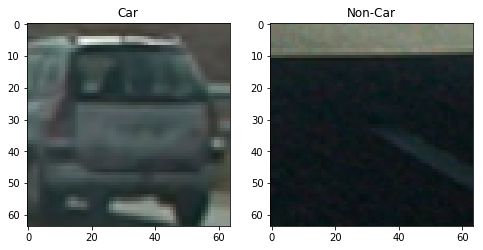

In [204]:
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.title('Car')
plt.imshow(car_img)

plt.subplot(122)
plt.title('Non-Car')
plt.imshow(non_car_img)

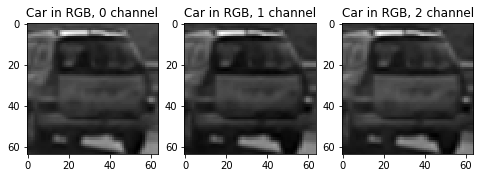

In [203]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    plot.set_title('Car in RGB, {} channel'.format(i))
    plot.imshow(car_img[:,:,i], cmap='gray')

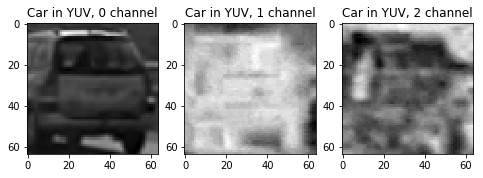

In [205]:
yuv_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    plot.set_title('Car in YUV, {} channel'.format(i))
    plot.imshow(yuv_car_img[:,:,i], cmap='gray')

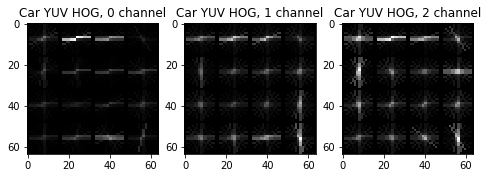

In [206]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    feature_vec, hog_img = get_hog_features(yuv_car_img[:,:,i], 11, 16, 2, True, True)
    plot.set_title('Car YUV HOG, {} channel'.format(i))
    plot.imshow(hog_img, cmap='gray')

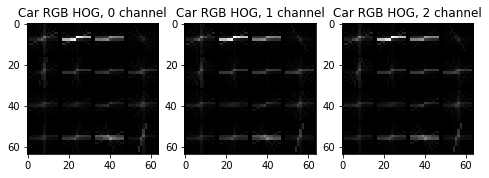

In [207]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    feature_vec, hog_img = get_hog_features(car_img[:,:,i], 11, 16, 2, True, True)
    plot.set_title('Car RGB HOG, {} channel'.format(i))
    plot.imshow(hog_img, cmap='gray')

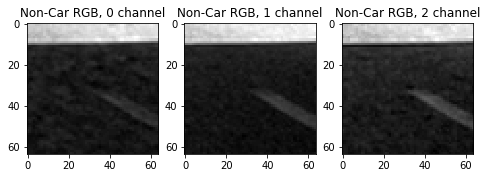

In [208]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    plot.set_title('Non-Car RGB, {} channel'.format(i))
    plot.imshow(non_car_img[:,:,i], cmap='gray')

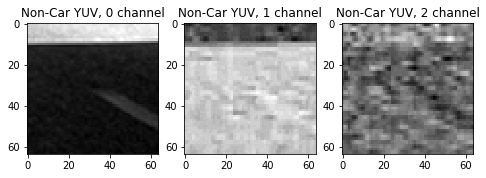

In [209]:
yuv_non_car_img = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2YUV)
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    plot.set_title('Non-Car YUV, {} channel'.format(i))
    plot.imshow(yuv_non_car_img[:,:,i], cmap='gray')

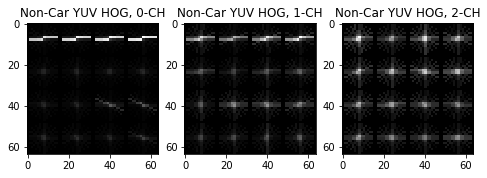

In [210]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    feature_vec, hog_img = get_hog_features(yuv_non_car_img[:,:,i], 11, 16, 2, True, True)
    plot.set_title('Non-Car YUV HOG, {}-CH'.format(i))
    plot.imshow(hog_img, cmap='gray')

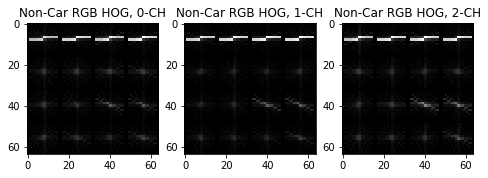

In [211]:
f, plts = plt.subplots(nrows=1, ncols=3, figsize=(8,8))
plts = plts.flatten()
for i, plot in enumerate(plts):
    feature_vec, hog_img = get_hog_features(non_car_img[:,:,i], 11, 16, 2, True, True)
    plot.set_title('Non-Car RGB HOG, {}-CH'.format(i))
    plot.imshow(hog_img, cmap='gray')

# Get HOG features

In [5]:
#### Feature Extractio Using HOG ####
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    
    hog_output = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                     cells_per_block=(cell_per_block, cell_per_block), 
                     visualise=vis, block_norm='L2', feature_vector=feature_vec)
    
    ## Call with two outputs if vis==True
    if vis == True:
        return hog_output[0], hog_output[1]
    ## Otherwise call with one output
    else:
        return hog_output

In [6]:
# Extract Important Features Using HOG Definition
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for i in imgs:
        image = mpimg.imread(i)
        if cspace != 'RGB':
            if cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            if cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        else: feature_image = np.copy(image)

        if hog_channel == 'ALL':
            hog_features = []
            if len(feature_image.shape) == 2:
                hog_features.append(get_hog_features(feature_image, 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            else:
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(hog_features)
    return features

In [7]:
#### Get Your HOG Features From Negitive and Positive Samples ####
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
## Get Features for Positive Samples
Features1 = extract_features(Cars, cspace=colorspace, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)
## Get Features for Negitive Samples
Features2 = extract_features(Non_Cars, cspace=colorspace, orient=orient, 
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                             hog_channel=hog_channel)

# Train a Support Vector Machine

In [8]:
## Create Features
X = np.vstack((Features1, Features2)).astype(np.float64)  
## Create Labels
y = np.hstack((np.ones(len(Features1)), np.zeros(len(Features2))))
## Split Training and Test Data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
                 X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# # Apply the scaler to X_train and test
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# X_train_scaled = X_train
# X_test_scaled = X_test

In [9]:
# Find best C for SVM classifier
parameters = {'C':list(range(1,10))}
svr = LinearSVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [10]:
clf.best_params_

{'C': 1}

## Create SVM classifier

In [37]:
svc = LinearSVC(C=1)
svc.fit(X_train_scaled, y_train)
print(classification_report(y_test, svc.predict(X_test_scaled)))

             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99      1811
        1.0       0.98      0.99      0.98      1741

avg / total       0.98      0.98      0.98      3552



In [38]:
## Show the Accuracy
print('Test Accuracy =', round(svc.score(X_test_scaled, y_test), 4))

Test Accuracy = 0.9848


# Sliding window search

In [13]:
#### Estimate the Location of Object of Interest and Draw Box Around Your Object 
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    rectangles = []  
    # Hack for 0-255 images
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        else: ctrans_tosearch = np.copy(img_tosearch)       
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    ## Compute HOG for Individual Channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
                
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            hog_features_scaled = X_scaler.transform([hog_features])
            test_prediction = svc.predict(hog_features_scaled)        
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
    return rectangles

In [14]:
## Draw Bounding Boxes ##
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [15]:
def draw_labeled_bboxes(img, labels):
    rects = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img, rects

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [17]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

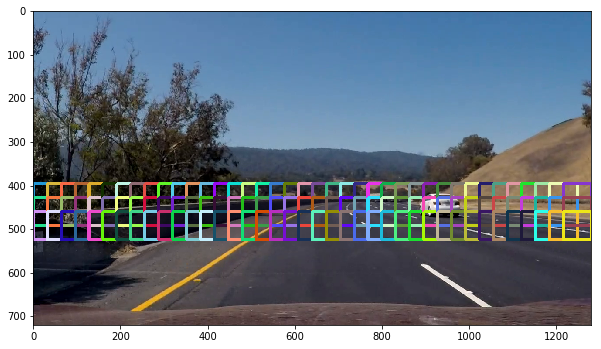

In [18]:
#### First Step Towards Finding the Object of Interest #### 
test_img = mpimg.imread('test_images/test7.jpg')[:,:,:3]

colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

ystart = 396
ystop = 550
scale = 1
rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell,
                       cell_per_block, None, None, True)
## Draw the Boxes Around the Image
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

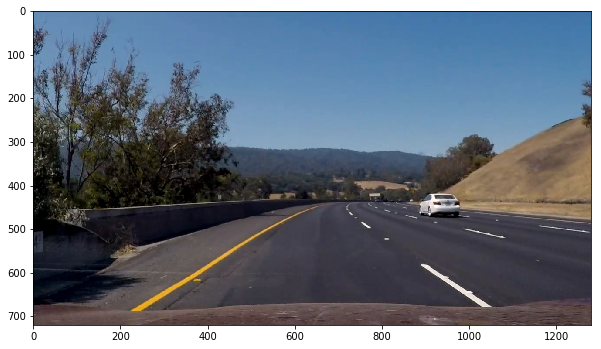

In [152]:
## Tune the Model on the Same Image ##
test_img = mpimg.imread('test_images/test7.jpg')[:,:,:3]
rects = []
ystart = 401
ystop = 500
scale = 1.3
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 400
ystop = 500
scale = 1.3
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

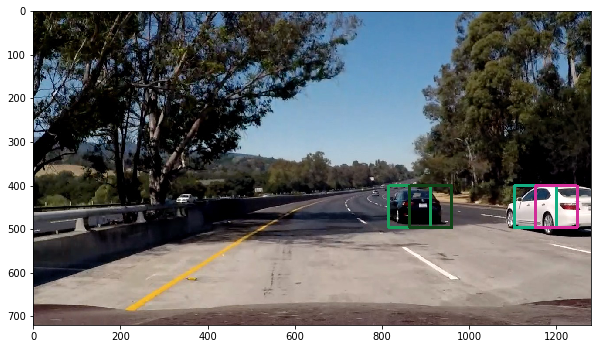

In [20]:
# Add medium boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 432
ystop = 526
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

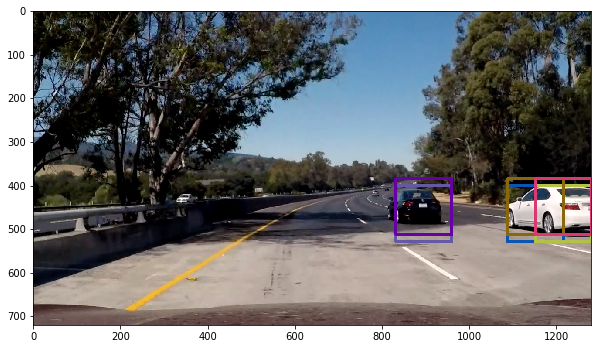

In [21]:
# Add medium boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 400
ystop = 528
scale = 2
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 384
ystop = 512
scale = 2
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

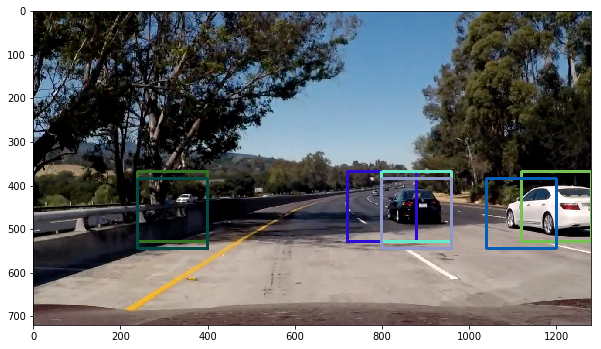

In [22]:
# Add large boxes
test_img = mpimg.imread('test_images/test5.jpg')
rects = []
ystart = 368
ystop = 592
scale = 2.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
ystart = 384
ystop = 656
scale = 2.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

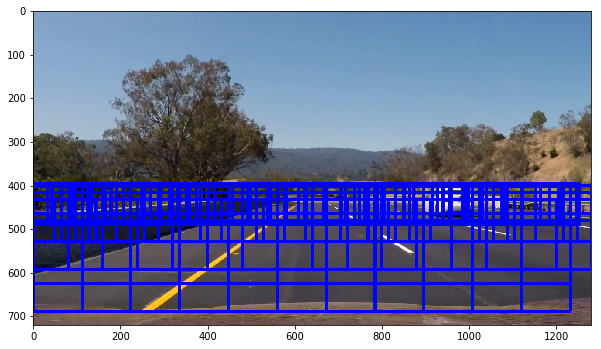

In [154]:
## Show search pattern
test_img = mpimg.imread('test_images/test8.jpg')[:,:,:3]
rectangles = []
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

# search_params = [[400, 496, 1.0], [416, 512, 1.0], [400, 550, 1.4], [432, 528, 1.5], 
#                  [384, 512, 2.0], [400, 528, 2.0], [432, 560, 2.0], [368, 528, 2.5],
#                  [384, 544, 2.5], [432, 656, 3.5]]

# search_params = [[400, 496, 1.0], [400, 550, 1.4], [432, 528, 1.5], 
#                  [384, 576, 2.0], [368, 560, 2.5], [432, 656, 3.5]]

search_params = [[400, 464, 1.0], [416, 480, 1.0], 
                 [400, 490, 1.3], [401, 500, 1.3],
                 [400, 490, 1.4], [395, 485, 1.4], 
                 [432, 528, 1.5], [400, 528, 2.0], 
                 [432, 592, 2.5],
                 [400, 624, 3.5], [464, 688, 3.5]]

for param in search_params:
    ystart = param[0]
    ystop = param[1]
    scale = param[2]
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, True))

rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

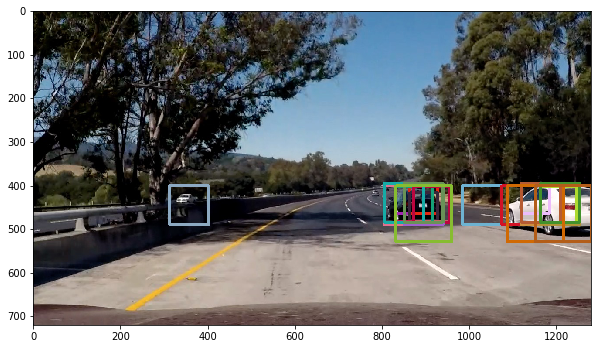

In [194]:
## Finally Tune the Model With More Accurate Location
test_img = mpimg.imread('test_images/test5.jpg')[:,:,:3]
rectangles = []
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

for param in search_params:
    ystart = param[0]
    ystop = param[1]
    scale = param[2]
    rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, None, None, False))
    
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, 'random')
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

2 cars found


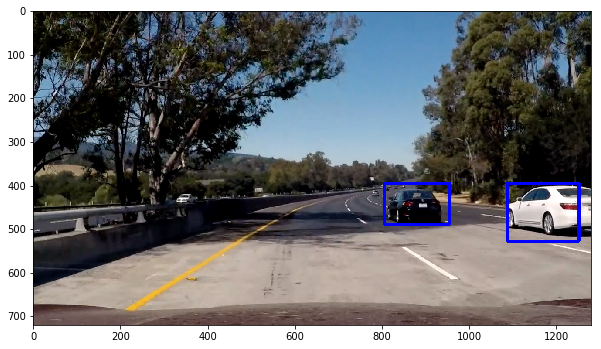

In [195]:
#### Draw The Bounding Boxes Around the Object of Interest
heatmap = np.zeros(test_img.shape[:2])
heatmap = add_heat(heatmap, rectangles)
heatmap_raw = heatmap.copy()
heatmap_th = apply_threshold(heatmap, 1)
labels = label(heatmap_th)
print(labels[1], 'cars found')


draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

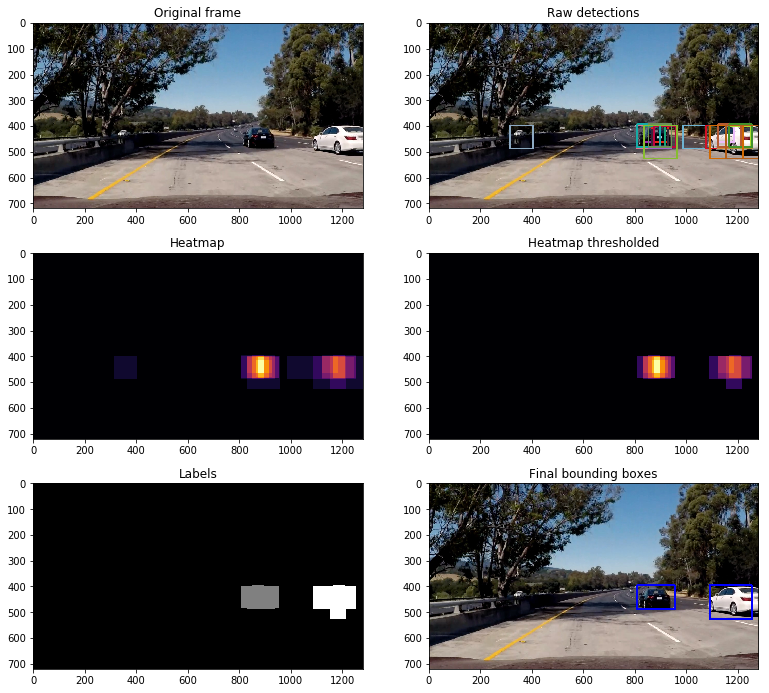

In [196]:
plt.figure(figsize=(13,12))

plt.subplot(321)
plt.title('Original frame')
plt.imshow(test_img)

plt.subplot(322)
plt.title('Raw detections')
plt.imshow(test_img_rects)

plt.subplot(323)
plt.title('Heatmap')
plt.imshow(heatmap_raw, cmap='inferno')

plt.subplot(324)
plt.title('Heatmap thresholded')
plt.imshow(heatmap_th, cmap='inferno')

plt.subplot(325)
plt.title('Labels')
plt.imshow(labels[0], cmap='gray')

plt.subplot(326)
plt.title('Final bounding boxes')
plt.imshow(draw_img)

# Final video pipeline

In [26]:
from queue import Queue

In [189]:
# Define the Complete PipLine for Object Detection 
class Detector():
    def __init__(self, svc, X_scaler, heatTh=5):
        self.svc = svc
        self.X_scaler = X_scaler
        self.Q = Queue()
        self.Q.maxsize = 8 # frames to lookup before
        self.colorspace = 'YUV'
        self.orient = 11
        self.pix_per_cell = 16
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.search_params = [[400, 464, 1.0], [416, 480, 1.0], 
                             [400, 490, 1.3], [401, 500, 1.3],
                             [400, 490, 1.4], [395, 485, 1.4], 
                             [432, 528, 1.5], [400, 528, 2.0], 
                             [432, 592, 2.5],
                             [400, 624, 3.5], [464, 688, 3.5]]
        self.heatTh = heatTh
        
    def process_frame(self, img):
        rectangles = []

        for param in self.search_params:
            ystart = param[0]
            ystop = param[1]
            scale = param[2]
            rectangles.append(find_cars(img, ystart, ystop, scale, self.colorspace, self.hog_channel, self.svc, 
                                        self.X_scaler, self.orient, self.pix_per_cell, self.cell_per_block, 
                                        None, None, False))
            
        # Focused search
        if not self.Q.empty():
            
            for last_rect in self.Q.queue[-1]:
                ystart = last_rect[0][1]
                ystop = last_rect[1][1]
                yscale = (ystop - ystart) / 64.0
                xscale = (last_rect[1][1] - last_rect[0][1]) / 64.0
                if (yscale >= 1.0) & (xscale >= 1.0):
                    rectangles.append(find_cars(img, ystart, ystop, yscale, self.colorspace, self.hog_channel, self.svc, 
                                        self.X_scaler, self.orient, self.pix_per_cell, self.cell_per_block, 
                                        None, None, False))

        rectangles = [item for sublist in rectangles for item in sublist]
        

        # Find rects only on the current frame detections
        heatmap_img = np.zeros(img.shape[:2])
        heatmap_img = add_heat(heatmap_img, rectangles)
        heatmap_img = apply_threshold(heatmap_img, 1)

        labels = label(heatmap_img) 

        draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)

        
        # add cur_rectangles to Q
        if self.Q.full():
            self.Q.get()
        
        self.Q.put(rects)

        if len(self.Q.queue)>1:
            rects = []
            # Add time series filtering
            for prev_rects in self.Q.queue:
                rects += prev_rects

            heatmap_img = np.zeros(img.shape[:2])
            heatmap_img = add_heat(heatmap_img, rects)
            heatmap_img = apply_threshold(heatmap_img, self.heatTh)

            labels = label(heatmap_img) 

            draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img

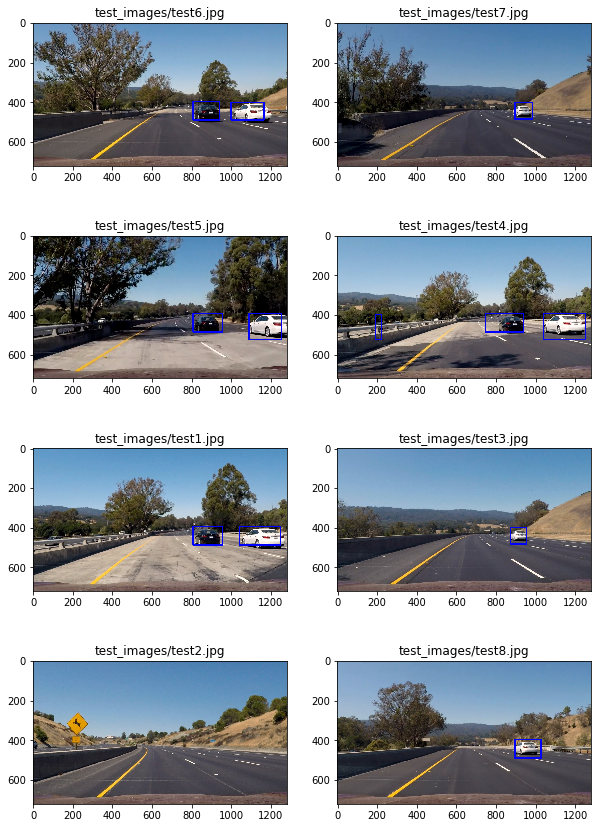

In [197]:
# Load the Test Images to Detect the Objects
test_images = glob.glob('test_images/*.jpg')

f, plts = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
plts = plts.flatten()
for i, imgPath in enumerate(test_images):
    
    drImg = Detector(svc, X_scaler, 1).process_frame(mpimg.imread(imgPath)[:,:,:3])
    plts[i].set_title(imgPath)
    plts[i].imshow(drImg)

## Process video

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [190]:
outputPath = "output_videos/project_video4_linear_q8_th5_focus_full.mp4"
inputPath = "project_video.mp4"

In [191]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
# clip1 = VideoFileClip(inputPath).subclip(15,20)
clip1 = VideoFileClip(inputPath)

In [192]:
det = Detector(svc, X_scaler)
output_clip = clip1.fl_image(det.process_frame) #NOTE: this function expects color images!!
%time output_clip.write_videofile(outputPath, audio=False)

[MoviePy] >>>> Building video output_videos/project_video4_linear_q8_th5_focus_full.mp4
[MoviePy] Writing video output_videos/project_video4_linear_q8_th5_focus_full.mp4


100%|█████████▉| 1260/1261 [26:14<00:01,  1.23s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video4_linear_q8_th5_focus_full.mp4 

CPU times: user 19min 15s, sys: 1min 41s, total: 20min 57s
Wall time: 26min 17s


In [193]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputPath))

In [34]:
# clip1 = VideoFileClip(inputPath)

# mpimg.imsave('test_images/test8.jpg', clip1.get_frame(20))

In [35]:
# clip1.fl_image()